In [1]:
# Install necessary libraries
!pip install -q datasets transformers
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate
!pip install onnx-tf



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import evaluate
from datasets import load_dataset

In [3]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:

# Setup: Specify model checkpoint, batch size, epochs, and learning rate.
model_checkpoint = "Jayanth2002/dinov2-base-finetuned-SkinDisease"  # Pre-trained model checkpoint
batch_size = 32
num_epochs = 10
learning_rate = 5e-5

In [5]:
# Try mounting to a subdirectory within /content/drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
ds = load_dataset("Muzmmillcoste/dermnet")
metric = evaluate.load("accuracy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13223 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2334 [00:00<?, ? examples/s]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})

In [8]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'], id=None)}

In [9]:
# Explore the dataset
print(ds)
print(ds["train"].features)

example = ds["train"][10]
print(example)
print("Image:", example['image'])
print("Label:", example['label'])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'S

In [10]:
# Create label mappings.
# Create label mappings.
labels = ds["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
print("Example mapping:", id2label[2])

Example mapping: Atopic Dermatitis Photos


In [11]:
# %%
from transformers import AutoImageProcessor
# Load the image processor from the model checkpoint.
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
print(image_processor)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}



In [12]:
# Define torchvision transforms based on the image processor.
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)


In [13]:


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
else:  # use shortest_edge if available
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)


train_transforms = Compose([
    RandomResizedCrop(crop_size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Validation transforms.
val_transforms = Compose([
    Resize(size),
    CenterCrop(crop_size),
    ToTensor(),
    normalize,
])

# Preprocessing functions to apply transforms to each batch.
def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


In [29]:
# %% [code]
# Split the training set into training and validation (90/10 split).
splits = ds["train"].train_test_split(test_size=0.25, seed=42)
train_ds = splits['train']
val_ds = splits['test']

# Apply preprocessing transforms.
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [30]:
# Define a collate function for DataLoader.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [31]:
# Create DataLoaders.
# Create DataLoaders with updated batch size
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



In [32]:
from transformers import AutoModelForImageClassification
# Load the pre-trained classification model.
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
print(model)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at Jayanth2002/dinov2-base-finetuned-SkinDisease and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([31, 1536]) in the checkpoint and torch.Size([23, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([31]) in the checkpoint and torch.Size([23]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [33]:
# Define loss and optimizer.
# Define loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)



In [34]:
# Calculate total training steps and set warmup steps (10% of total steps).
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps))


In [35]:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps)
)

In [36]:
gradient_accumulation_steps = 4


In [37]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Define gradient accumulation steps
gradient_accumulation_steps = 4

# Lists to store metrics for each epoch.
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    optimizer.zero_grad()  # Initialize gradients at the start of each epoch

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        # Scale the loss for gradient accumulation.
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Accumulate the unscaled loss for reporting.
        running_loss += loss.item() * inputs.size(0) * gradient_accumulation_steps

        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total_train += inputs.size(0)

        # If we've accumulated enough batches, perform an optimizer step.
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()  # Update learning rate as per the scheduler

    # Handle the case where total batches is not a multiple of accumulation steps.
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    train_epoch_loss = running_loss / total_train
    train_epoch_acc = running_correct / total_train
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_epoch_loss:.4f} - Training Acc: {train_epoch_acc:.4f}")

    # Validation loop.
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    total_val = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        val_running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        val_correct += (preds == labels).sum().item()
        total_val += inputs.size(0)

    val_epoch_loss = val_running_loss / total_val
    val_epoch_acc = val_correct / total_val
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}")
    model.train()


Epoch 1/10 - Training Loss: 2.4575 - Training Acc: 0.3066


Epoch 1/10 - Validation Loss: 1.9919 - Validation Acc: 0.4071


Epoch 2/10 - Training Loss: 1.7625 - Training Acc: 0.4731


Epoch 2/10 - Validation Loss: 1.7347 - Validation Acc: 0.4716


Epoch 3/10 - Training Loss: 1.4775 - Training Acc: 0.5567


Epoch 3/10 - Validation Loss: 1.5471 - Validation Acc: 0.5496


Epoch 4/10 - Training Loss: 1.2719 - Training Acc: 0.6141


Epoch 4/10 - Validation Loss: 1.5205 - Validation Acc: 0.5532


Epoch 5/10 - Training Loss: 1.1094 - Training Acc: 0.6576


Epoch 5/10 - Validation Loss: 1.4122 - Validation Acc: 0.5862


Epoch 6/10 - Training Loss: 0.8997 - Training Acc: 0.7288


Epoch 6/10 - Validation Loss: 1.4018 - Validation Acc: 0.6019


Epoch 7/10 - Training Loss: 0.7494 - Training Acc: 0.7662


Epoch 7/10 - Validation Loss: 1.3717 - Validation Acc: 0.6062


Epoch 8/10 - Training Loss: 0.6266 - Training Acc: 0.8062


Epoch 8/10 - Validation Loss: 1.4344 - Validation Acc: 0.6183


Epoch 9/10 - Training Loss: 0.5604 - Training Acc: 0.8244


Epoch 9/10 - Validation Loss: 1.3785 - Validation Acc: 0.6373


Epoch 10/10 - Training Loss: 0.4791 - Training Acc: 0.8543


Epoch 10/10 - Validation Loss: 1.4274 - Validation Acc: 0.6276


In [38]:
# Save the model locally (to your Google Drive).
save_path = "/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft"
model.save_pretrained(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft


In [46]:
# Ensure you have defined test_ds and created test_loader
test_ds = ds["test"]  # Or use ds["train"] if that's your test split
test_ds.set_transform(preprocess_val)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [47]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

model.eval()
predicted_labels = []
actual_labels = []

for batch in tqdm(test_loader, desc="Testing", leave=False):
    inputs = batch["pixel_values"].to(device)
    outputs = model(inputs).logits
    preds = outputs.argmax(dim=1)
    predicted_labels.extend(preds.cpu().numpy())
    actual_labels.extend(batch["labels"].cpu().numpy())

test_acc = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.6487


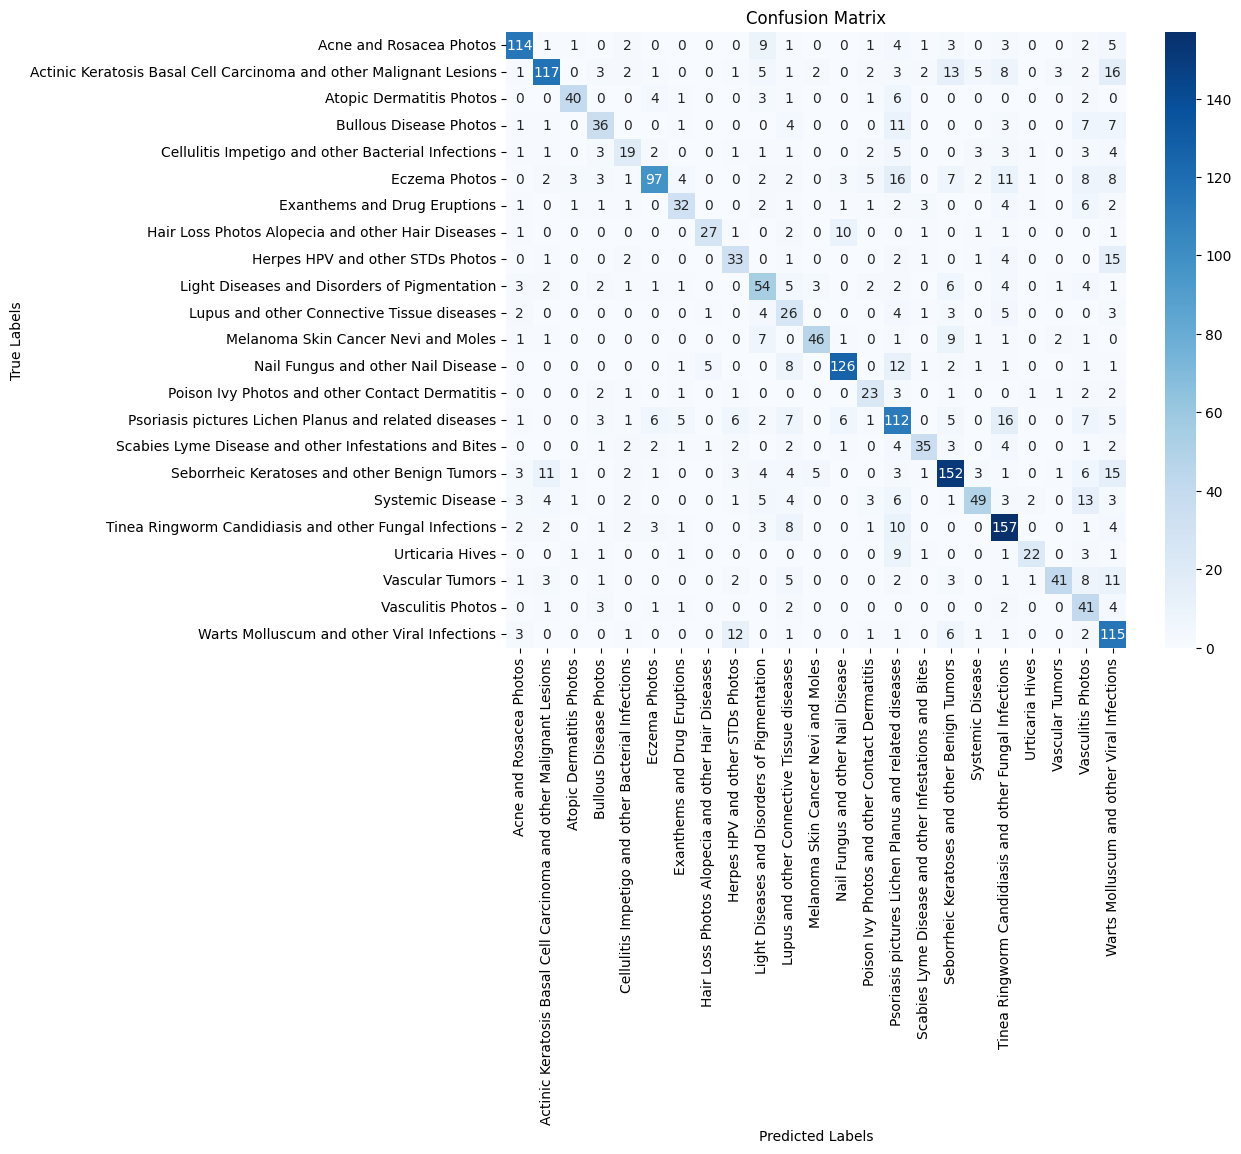

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.83      0.78      0.80       147
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.80      0.63      0.70       187
                                          Atopic Dermatitis Photos       0.83      0.69      0.75        58
                                            Bullous Disease Photos       0.60      0.51      0.55        71
                Cellulitis Impetigo and other Bacterial Infections       0.49      0.38      0.43        50
                                                     Eczema Photos       0.82      0.55      0.66       175
                                      Exanthems and Drug Eruptions       0.64      0.54      0.59        59
                 Hair Loss Photos Alopecia and other Hair Diseases       0.79      0.60      0.68        45
    

In [49]:
# Generate and display confusion matrix.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 8))
# Access class names from the 'label' feature in the dataset
class_names = ds["test"].features["label"].names
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report.
report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

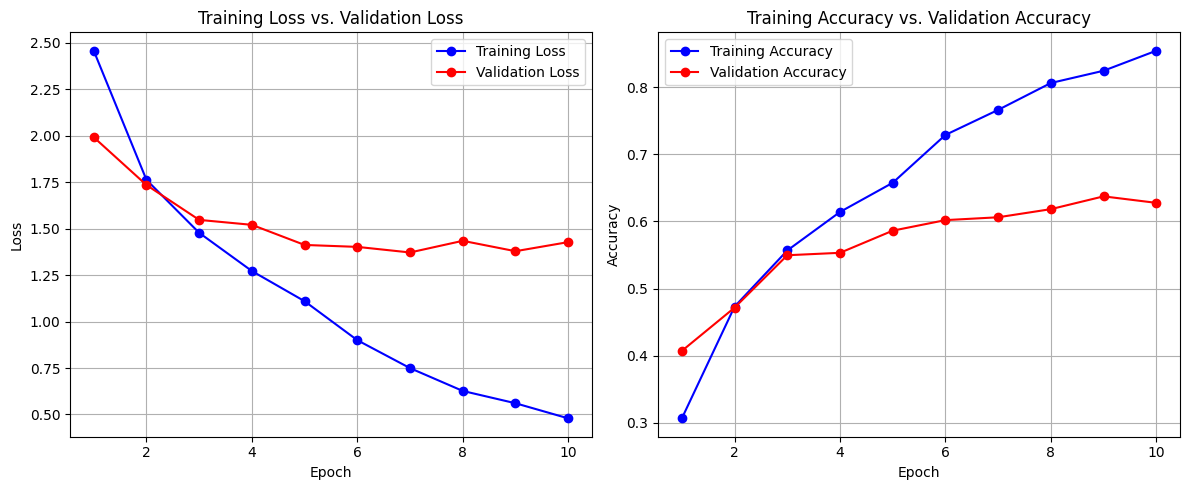

In [41]:
# Plotting the Losses.
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs, val_losses, marker='o', linestyle='-', label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Validation Loss")
plt.legend()
plt.grid(True)

# Plotting the Accuracies.
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs. Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Define the path to your test folder.
test_folder = "/content/drive/MyDrive/extracted_skin/Dermnet/Test_Folder"

# Use the validation transforms (assumed defined as val_transforms) for test images.
# If you already have a preprocess_val function, you can also create a transform pipeline equivalent.
# For example:
# val_transforms = Compose([
#     Resize(size),
#     CenterCrop(crop_size),
#     ToTensor(),
#     normalize,
# ])

# Create an ImageFolder dataset from the test folder.
test_ds = ImageFolder(root=test_folder, transform=val_transforms)

# Create a DataLoader for the test dataset.
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Run inference and compute accuracy.
model.eval()
predicted_labels = []
actual_labels = []

for batch in tqdm(test_loader, desc="Testing", leave=False):
    inputs, labels = batch
    inputs = inputs.to(device)
    outputs = model(inputs).logits
    preds = outputs.argmax(dim=1)
    predicted_labels.extend(preds.cpu().numpy())
    actual_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7840


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

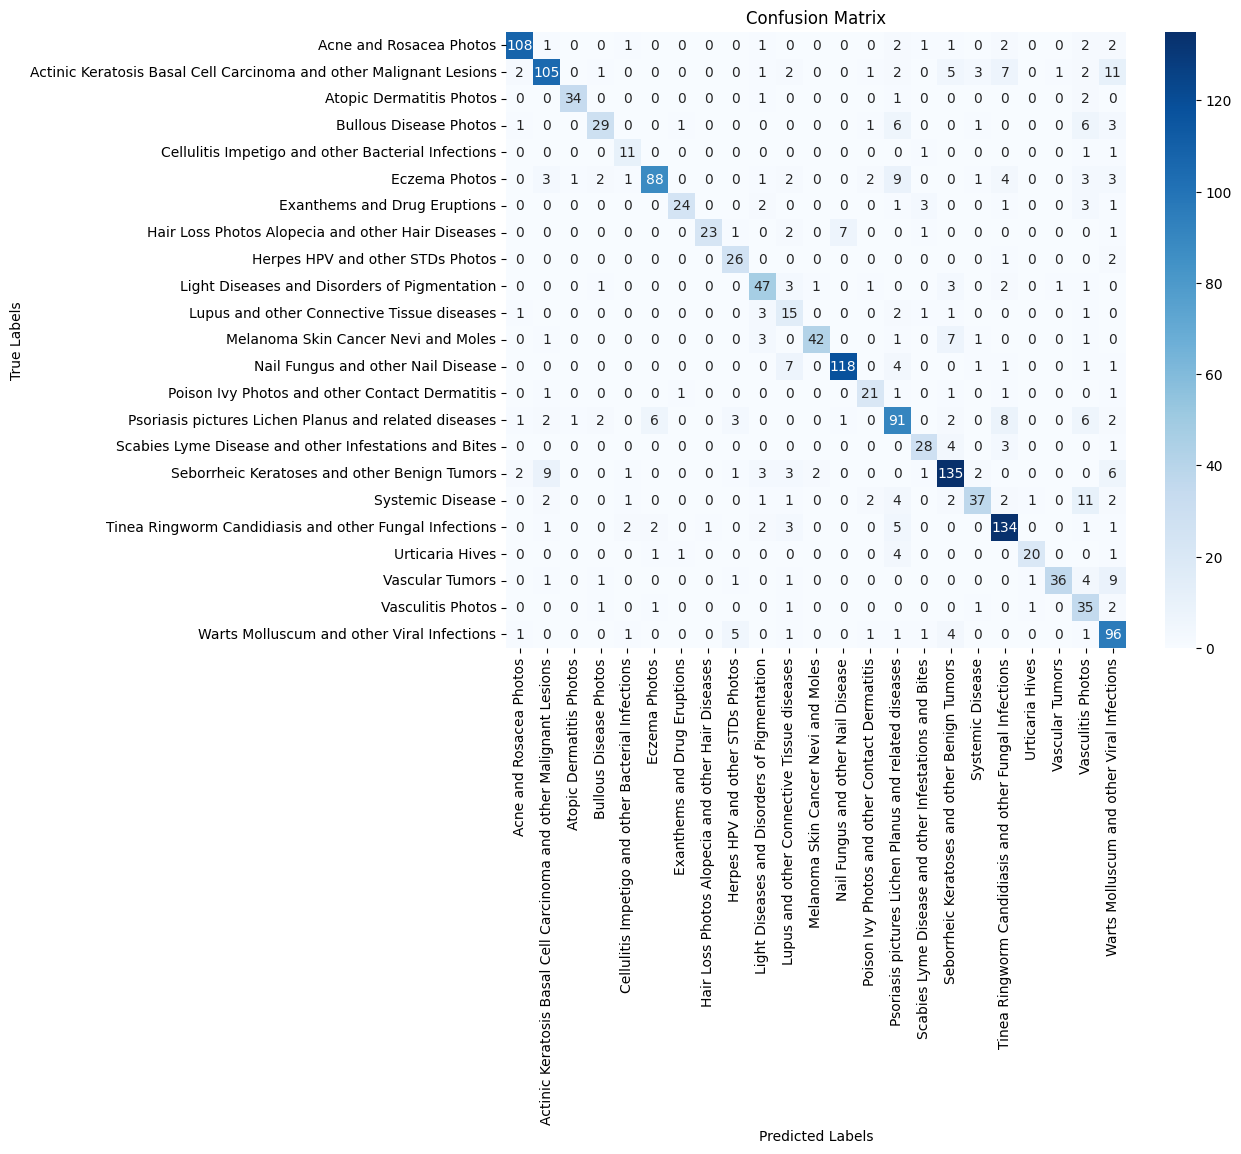

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.93      0.89      0.91       121
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.83      0.73      0.78       143
                                          Atopic Dermatitis Photos       0.94      0.89      0.92        38
                                            Bullous Disease Photos       0.78      0.60      0.68        48
                Cellulitis Impetigo and other Bacterial Infections       0.61      0.79      0.69        14
                                                     Eczema Photos       0.90      0.73      0.81       120
                                      Exanthems and Drug Eruptions       0.89      0.69      0.77        35
                 Hair Loss Photos Alopecia and other Hair Diseases       0.96      0.66      0.78        35
    

In [44]:
# Generate and display confusion matrix.
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes,
            yticklabels=test_ds.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report.
report = classification_report(actual_labels, predicted_labels, target_names=test_ds.classes)
print("Classification Report:")
print(report)